## Часть 4.
### Построение модели и тюнинг гиперпараметров.

**Оглавление**
* Разделы:
    * [1. Базовая модель](#bload)
    * [2. Подбор гиперпараметров](#exp)
    * [3. Финальная модель](#end)

In [ ]:
#!pip install catboost
# conda install scikit-learn
# !pip install scikit-learn==0.22
# !pip install bayesian-optimization

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import gmean, rankdata

from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve

import catboost as ctb
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
my_train_old = pd.read_csv(r"./competitive-data-analysis_coursework/train_ready.csv")
my_test_old = pd.read_csv(r"./competitive-data-analysis_coursework/test_ready.csv")

In [3]:
my_train_old.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,DAYS_DECISION,SELLERPLACE_AREA,AMOUNT_ANNUITY/TOTAL_SALARY,AMOUNT_CREDIT/AMOUNT_ANNUITY,TOTAL_SALARY*REGION_POPULATION,EXTERNAL_SR3*AMOUNT_CREDIT,EXTERNAL_SR2*AMOUNT_ANNUITY,EXTERNAL_SR3*AMOUNT_ANNUITY,mean_EXTERNAL_SR,sum_EXTERNAL_SR
0,123687442,0,0.013188,0.087802,157500.0,855000.0,25128.0,0.014295,0.090711,0.019101,...,2702.0,3,0.159543,34.025787,3008.4075,612667.56,16230.521,18005.977,0.687756,2.063268
1,123597908,1,0.013188,0.043765,0.0,0.0,0.0,0.043765,0.043765,0.000000,...,903.0,4,0.000000,0.000000,0.0000,0.00,0.000,0.000,0.000000,0.000000


In [4]:
my_test_old.head(2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,DAYS_DECISION,SELLERPLACE_AREA,AMOUNT_ANNUITY/TOTAL_SALARY,AMOUNT_CREDIT/AMOUNT_ANNUITY,TOTAL_SALARY*REGION_POPULATION,EXTERNAL_SR3*AMOUNT_CREDIT,EXTERNAL_SR2*AMOUNT_ANNUITY,EXTERNAL_SR3*AMOUNT_ANNUITY,mean_EXTERNAL_SR,sum_EXTERNAL_SR
0,123724268,0.013188,0.087802,117000.0,1125000.0,32895.0,0.014295,0.090711,0.028663,16007.0,...,720.0,4,0.281154,34.199726,3353.571,0.000,20666.814,0.0000,0.209422,0.628266
1,123456549,0.013188,0.073746,81000.0,312768.0,17095.5,0.014295,0.090711,0.019689,10315.0,...,1069.0,2,0.211056,18.295341,1594.809,58953.492,9883.951,3222.3228,0.255550,0.766651


In [5]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
  
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)
        y_valid_pred = estimator.predict_proba(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred[:,1]))
        fold_valid_scores.append(metric(y_valid, y_valid_pred[:,1]))
        oof_predictions[valid_idx] = y_valid_pred[:,1]

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")
    
    print(estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions)
    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

#### 1. Базовая модель.  <a class='anchor' id='bload'>

In [7]:
X = my_train_old.drop("TARGET", axis=1)
y = my_train_old["TARGET"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=99)

In [8]:
params_ctb = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 25,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 99
}

In [9]:
model_ctb_old = CatBoostClassifier(**params_ctb)
model_ctb_old.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=200)

0:	test: 0.6362334	test1: 0.6347121	best: 0.6347121 (0)	total: 82.7ms	remaining: 1m 22s
200:	test: 0.7304733	test1: 0.7195827	best: 0.7196155 (199)	total: 4.77s	remaining: 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7233985654
bestIteration = 318

Shrink model to first 319 iterations.


#### 2. Подбор гиперпараметров.  <a class='anchor' id='exp'>

In [15]:
def catboost_old_optimize_params(n_estimators, max_depth, learning_rate, l2_leaf_reg, max_bin, thread_count, min_child_samples, subsample):
    params_ctb["n_estimators"]= int(n_estimators)
    params_ctb["max_depth"] = int(max_depth)
    params_ctb["learning_rate"] = learning_rate
    params_ctb["l2_leaf_reg"]= int(l2_leaf_reg)
    params_ctb["max_bin"]= int(max_bin)
    params_ctb["thread_count"]= int(thread_count)
    params_ctb["min_child_samples"]= int(min_child_samples)
    params_ctb["subsample"] = subsample

    model_ctb_old = CatBoostClassifier(**params_ctb)
    model_ctb_old.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

    return roc_auc_score(y_valid, model_ctb_old.predict_proba(X_valid)[:,1])

In [16]:
ctb_params_search = BayesianOptimization(
    f=catboost_old_optimize_params,
    pbounds={
        "n_estimators": (1000, 2000),
        "max_depth": (2, 10),
        'learning_rate': (0.01, 0.5),
        "l2_leaf_reg": (150, 300),
        "max_bin": (100, 350),
        "thread_count": (10, 30),
        'min_child_samples': (100, 250),
        'subsample': (0.3, 0.8)
    },
    random_state=99
)

ctb_params_search.maximize(init_points=5, n_iter=3, acq='ei')

|   iter    |  target   | l2_lea... | learni... |  max_bin  | max_depth | min_ch... | n_esti... | subsample | thread... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7277   |  250.8    |  0.2492   |  306.4    |  2.094    |  221.2    |  1.566e+0 |  0.4488   |  10.93    |
|  2        |  0.7264   |  298.6    |  0.01334  |  292.4    |  4.24     |  156.6    |  1.494e+0 |  0.7645   |  17.91    |
|  3        |  0.7254   |  296.1    |  0.267    |  123.4    |  4.44     |  131.8    |  1.554e+0 |  0.4461   |  26.32    |
|  4        |  0.7267   |  274.2    |  0.1186   |  261.2    |  2.286    |  161.7    |  1.097e+0 |  0.372    |  14.24    |
|  5        |  0.724    |  221.5    |  0.04803  |  158.8    |  2.02     |  234.8    |  1.552e+0 |  0.3838   |  28.58    |
|  6        |  0.728    |  255.1    |  0.3906   |  316.5    |  4.486    |  199.1    |  1.573e+0 |  0.7136   |  19.19    |
|  7        |  0.7261   

In [25]:
params_ctb2 = {
    "silent": True,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "early_stopping_rounds": 550,
    "random_state": 99,
    'l2_leaf_reg': 221.498423168379,
    'learning_rate': 0.03,
    'max_bin': 158,
    'max_depth': 3,
    'min_child_samples': 234.79662806085997,
    'n_estimators': 6552,
    'subsample': 0.3,
    'thread_count': 28
}

In [26]:
model_ctb_old = CatBoostClassifier(**params_ctb2)
model_ctb_old.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=200)

0:	test: 0.5360167	test1: 0.5366264	best: 0.5366264 (0)	total: 45.9ms	remaining: 5m
200:	test: 0.7159019	test1: 0.7139479	best: 0.7139479 (200)	total: 9.04s	remaining: 4m 45s
400:	test: 0.7267927	test1: 0.7225879	best: 0.7225879 (400)	total: 17.9s	remaining: 4m 35s
600:	test: 0.7337414	test1: 0.7247099	best: 0.7248238 (582)	total: 26.6s	remaining: 4m 23s
800:	test: 0.7384236	test1: 0.7257974	best: 0.7258001 (792)	total: 35.5s	remaining: 4m 14s
1000:	test: 0.7425444	test1: 0.7263031	best: 0.7263098 (999)	total: 44.6s	remaining: 4m 7s
1200:	test: 0.7457349	test1: 0.7271327	best: 0.7271327 (1200)	total: 53.3s	remaining: 3m 57s
1400:	test: 0.7485991	test1: 0.7271299	best: 0.7272004 (1384)	total: 1m 2s	remaining: 3m 48s
1600:	test: 0.7515017	test1: 0.7276123	best: 0.7276275 (1592)	total: 1m 10s	remaining: 3m 39s
1800:	test: 0.7541075	test1: 0.7276957	best: 0.7277222 (1610)	total: 1m 19s	remaining: 3m 29s
2000:	test: 0.7563668	test1: 0.7279913	best: 0.7280465 (1975)	total: 1m 28s	remaining: 

In [27]:
cv_strategy = KFold(n_splits=5)

estimators_ctb1, oof_score_ctb1, fold_train_scores_ctb1, fold_valid_scores_ctb1, oof_predictions_ctb1 = make_cross_validation(
    my_train_old.drop('TARGET', axis=1), my_train_old['TARGET'], model_ctb_old, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7896, valid-score = 0.7256
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.792, valid-score = 0.7218
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7882, valid-score = 0.7315
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7911, valid-score = 0.7226
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7869, valid-score = 0.7318
CV-results train: 0.7896 +/- 0.002
CV-results valid: 0.7267 +/- 0.004
OOF-score = 0.7263
[<catboost.core.CatBoostClassifier object at 0x0000020568037148>, <catboost.core.CatBoostClassifier object at 0x0000020568037148>, <catboost.core.CatBoostClassifier object at 0x0000020568037148>, <catboost.core.CatBoostClassifier object at 0x0000020568037148>, <catboost.core.CatBoostClassifier object at 0x0000020568037148>] 0.7263087986063659 [0.7895715407328654, 0.791970014

In [ ]:
# Второй катбуст

In [94]:
params_ctb3 = {
    "silent": True,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "early_stopping_rounds": 550,
    "random_state": 99,
    
    'l2_leaf_reg': 250.84178379461878,
    'learning_rate': 0.24915841562788602,
    'max_bin': 306,
    'max_depth': 2,
    'min_child_samples': 221.20749450472715,
    'n_estimators': 4552,
    'subsample': 0.3785734992223664,
    'thread_count': 11
}

In [95]:
model_ctb_old2 = CatBoostClassifier(**params_ctb3)
model_ctb_old2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=200)

0:	test: 0.5000053	test1: 0.5003133	best: 0.5003133 (0)	total: 24.1ms	remaining: 1m 49s
200:	test: 0.7397514	test1: 0.7245868	best: 0.7247035 (178)	total: 4.3s	remaining: 1m 33s
400:	test: 0.7503788	test1: 0.7276798	best: 0.7277036 (393)	total: 8.62s	remaining: 1m 29s
600:	test: 0.7593838	test1: 0.7277883	best: 0.7281743 (456)	total: 12.9s	remaining: 1m 25s
800:	test: 0.7652483	test1: 0.7264449	best: 0.7281743 (456)	total: 17.3s	remaining: 1m 21s
1000:	test: 0.7714824	test1: 0.7259830	best: 0.7281743 (456)	total: 21.6s	remaining: 1m 16s
Stopped by overfitting detector  (550 iterations wait)

bestTest = 0.7281743304
bestIteration = 456

Shrink model to first 457 iterations.


In [96]:
cv_strategy = KFold(n_splits=5)

estimators_ctb2, oof_score_ctb2, fold_train_scores_ctb2, fold_valid_scores_ctb2, oof_predictions_ctb2 = make_cross_validation(
    my_train_old.drop('TARGET', axis=1), my_train_old['TARGET'], model_ctb_old2, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.8288, valid-score = 0.7156
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.8277, valid-score = 0.7132
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.8257, valid-score = 0.7226
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.8276, valid-score = 0.7108
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.8259, valid-score = 0.7181
CV-results train: 0.8271 +/- 0.001
CV-results valid: 0.7161 +/- 0.004
OOF-score = 0.7158
[<catboost.core.CatBoostClassifier object at 0x0000020567B21088>, <catboost.core.CatBoostClassifier object at 0x0000020567B21088>, <catboost.core.CatBoostClassifier object at 0x0000020567B21088>, <catboost.core.CatBoostClassifier object at 0x0000020567B21088>, <catboost.core.CatBoostClassifier object at 0x0000020567B21088>] 0.7158190969576974 [0.82875882224858, 0.8276589130

In [ ]:
# третий катбуст

In [97]:
params_ctb4 = {
    "silent": True,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "early_stopping_rounds": 550,
    "random_state": 99,
    'l2_leaf_reg': 221.498423168379,
    'learning_rate': 0.026,
    'max_bin': 158,
    'max_depth': 2,
    'min_child_samples': 234.79662806085997,
    'n_estimators': 6552,
    'subsample': 0.3,
    'thread_count': 28
}

In [98]:
model_ctb_old3 = CatBoostClassifier(**params_ctb4)
model_ctb_old3.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=200)

0:	test: 0.5000053	test1: 0.5003133	best: 0.5003133 (0)	total: 18.8ms	remaining: 2m 2s
200:	test: 0.7068586	test1: 0.7041225	best: 0.7041723 (198)	total: 8.07s	remaining: 4m 15s
400:	test: 0.7159252	test1: 0.7144106	best: 0.7144106 (400)	total: 16s	remaining: 4m 4s
600:	test: 0.7227673	test1: 0.7204049	best: 0.7204049 (600)	total: 23.7s	remaining: 3m 54s
800:	test: 0.7264995	test1: 0.7229479	best: 0.7229817 (794)	total: 31.7s	remaining: 3m 47s
1000:	test: 0.7294242	test1: 0.7245276	best: 0.7245276 (1000)	total: 39.8s	remaining: 3m 40s
1200:	test: 0.7319049	test1: 0.7250390	best: 0.7250390 (1200)	total: 47.8s	remaining: 3m 32s
1400:	test: 0.7342331	test1: 0.7253756	best: 0.7254754 (1331)	total: 55.8s	remaining: 3m 25s
1600:	test: 0.7361106	test1: 0.7256568	best: 0.7256601 (1599)	total: 1m 3s	remaining: 3m 17s
1800:	test: 0.7382410	test1: 0.7264898	best: 0.7264898 (1800)	total: 1m 11s	remaining: 3m 8s
2000:	test: 0.7397733	test1: 0.7266759	best: 0.7267330 (1956)	total: 1m 19s	remaining: 

In [99]:
cv_strategy = KFold(n_splits=5)

estimators_ctb3, oof_score_ctb3, fold_train_scores_ctb3, fold_valid_scores_ctb3, oof_predictions_ctb3 = make_cross_validation(
    my_train_old.drop('TARGET', axis=1), my_train_old['TARGET'], model_ctb_old3, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7599, valid-score = 0.7245
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7621, valid-score = 0.7224
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.759, valid-score = 0.732
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7606, valid-score = 0.7242
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7579, valid-score = 0.7348
CV-results train: 0.7599 +/- 0.001
CV-results valid: 0.7276 +/- 0.005
OOF-score = 0.7272
[<catboost.core.CatBoostClassifier object at 0x00000205681EE4C8>, <catboost.core.CatBoostClassifier object at 0x00000205681EE4C8>, <catboost.core.CatBoostClassifier object at 0x00000205681EE4C8>, <catboost.core.CatBoostClassifier object at 0x00000205681EE4C8>, <catboost.core.CatBoostClassifier object at 0x00000205681EE4C8>] 0.7271973687892758 [0.7598679419144506, 0.7621125679

In [100]:
scores = pd.DataFrame({
    "ctb1": oof_predictions_ctb1,
    "ctb2": oof_predictions_ctb2,
    'ctb3': oof_predictions_ctb3
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

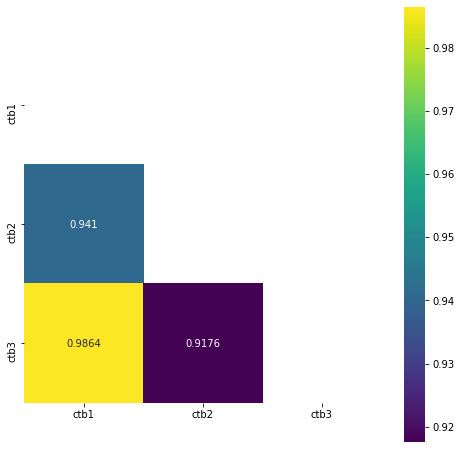

In [101]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Корреляция близка к высокой, однако все еще возможно улучшение качества комбинации моделей.

#### 3. Финальная модель.  <a class='anchor' id='end'>

In [104]:
eclf2 = VotingClassifier(estimators=[
    ('ctb1', model_ctb_old),
    ('ctb2', model_ctb_old2),
    ('ctb3', model_ctb_old3)
  ],
                         voting='soft')

In [105]:
eclf2.fit(my_train_old.drop('TARGET', axis=1), my_train_old['TARGET'])

VotingClassifier(estimators=[('ctb1',
                              <catboost.core.CatBoostClassifier object at 0x0000020568037148>),
                             ('ctb2',
                              <catboost.core.CatBoostClassifier object at 0x0000020567B21088>),
                             ('ctb3',
                              <catboost.core.CatBoostClassifier object at 0x00000205681EE4C8>)],
                 voting='soft')

In [106]:
len(eclf2.predict_proba(my_test_old)[:,1])

165141

In [107]:
sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")
sample_submit['TARGET'] = eclf2.predict_proba(my_test_old)[:,1].tolist()
sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kaggle.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.062846
1,123456549,0.251945
2,123428178,0.171311
3,123619984,0.081737
4,123671104,0.022742
...,...,...
165136,123487967,0.089997
165137,123536402,0.061982
165138,123718238,0.088406
165139,123631557,0.015896


#### Вывод <a class='anchor' id='end'> 

В результате нескольких итераций выполнения вышепроизведенных действий качество roc_auc на лидерборде kaggle составило 0.73290